In [1]:
!nvidia-smi

Tue May 21 15:21:20 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:47:00.0 Off |                    0 |
| N/A   31C    P0    71W / 400W |  61776MiB / 81251MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
print(torch.__version__)
import torchvision
print(torchvision.__version__)
print(torch.cuda.get_device_name(0))

1.12.1
0.13.1
NVIDIA A100-SXM4-80GB


In [3]:
import torch.nn.functional as F
from torch import nn
from einops import rearrange
from einops.layers.torch import Rearrange
import numpy as np

In [4]:
class SwinEmbedding(nn.Module):
    def __init__(self, patch_size=4, emb_size=96):
        super().__init__()
        self.linear_embedding = nn.Conv2d(3, emb_size, kernel_size = patch_size, stride = patch_size)
        self.rearrange = Rearrange('b c h w -> b (h w) c')
        
    def forward(self, x):
        x = self.linear_embedding(x)
        x = self.rearrange(x)
        return x

In [5]:
class PatchMerging(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.linear = nn.Linear(4*emb_size, 2*emb_size)

    def forward(self, x):
        B, L, C = x.shape
        H = W = int(np.sqrt(L)/2)
        x = rearrange(x, 'b (h s1 w s2) c -> b (h w) (s1 s2 c)', s1=2, s2=2, h=H, w=W)
        x = self.linear(x)
        return x

In [6]:
class ShiftedWindowMSA(nn.Module):
    def __init__(self, emb_size, num_heads, window_size=7, shifted=True):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.window_size = window_size
        self.shifted = shifted
        self.linear1 = nn.Linear(emb_size, 3*emb_size)
        self.linear2 = nn.Linear(emb_size, emb_size)
        self.pos_embeddings = nn.Parameter(torch.randn(window_size*2 - 1, window_size*2 - 1))
        self.indices = torch.tensor(np.array([[x, y] for x in range(window_size) for y in range(window_size)]))
        self.relative_indices = self.indices[None, :, :] - self.indices[:, None, :]
        self.relative_indices += self.window_size - 1
    def forward(self, x):
        h_dim = self.emb_size / self.num_heads
        height = width = int(np.sqrt(x.shape[1]))
        x = self.linear1(x)
        
        x = rearrange(x, 'b (h w) (c k) -> b h w c k', h=height, w=width, k=3, c=self.emb_size)
        
        if self.shifted:
            x = torch.roll(x, (-self.window_size//2, -self.window_size//2), dims=(1,2))
        
        x = rearrange(x, 'b (Wh w1) (Ww w2) (e H) k -> b H Wh Ww (w1 w2) e k', w1 = self.window_size, w2 = self.window_size, H = self.num_heads)            
        
        Q, K, V = x.chunk(3, dim=6)
        Q, K, V = Q.squeeze(-1), K.squeeze(-1), V.squeeze(-1)
        wei = (Q @ K.transpose(4,5)) / np.sqrt(h_dim)
        
        rel_pos_embedding = self.pos_embeddings[self.relative_indices[:, :, 0], self.relative_indices[:, :, 1]]
        wei += rel_pos_embedding
        
        if self.shifted:
            row_mask = torch.zeros((self.window_size**2, self.window_size**2)).cuda()
            row_mask[-self.window_size * (self.window_size//2):, 0:-self.window_size * (self.window_size//2)] = float('-inf')
            row_mask[0:-self.window_size * (self.window_size//2), -self.window_size * (self.window_size//2):] = float('-inf')
            column_mask = rearrange(row_mask, '(r w1) (c w2) -> (w1 r) (w2 c)', w1=self.window_size, w2=self.window_size)
            wei[:, :, -1, :] += row_mask
            wei[:, :, :, -1] += column_mask
        
        wei = F.softmax(wei, dim=-1) @ V
        
        x = rearrange(wei, 'b H Wh Ww (w1 w2) e -> b (Wh w1) (Ww w2) (H e)', w1 = self.window_size, w2 = self.window_size, H = self.num_heads)
        x = rearrange(x, 'b h w c -> b (h w) c')
        
        return self.linear2(x)

In [7]:
class MLP(nn.Module):
    def __init__(self, emb_size):
        super().__init__()
        self.ff = nn.Sequential(
                         nn.Linear(emb_size, 4*emb_size),
                         nn.GELU(),
                         nn.Linear(4*emb_size, emb_size),
                  )
    
    def forward(self, x):
        return self.ff(x)
    
class SwinEncoder(nn.Module):
    def __init__(self, emb_size, num_heads, window_size=7):
        super().__init__()
        self.WMSA = ShiftedWindowMSA(emb_size, num_heads, window_size, shifted=False)
        self.SWMSA = ShiftedWindowMSA(emb_size, num_heads, window_size, shifted=True)
        self.ln = nn.LayerNorm(emb_size)
        self.MLP = MLP(emb_size)
        
    def forward(self, x):
        # Window Attention
        x = x + self.WMSA(self.ln(x))
        x = x + self.MLP(self.ln(x))
        # shifted Window Attention
        x = x + self.SWMSA(self.ln(x))
        x = x + self.MLP(self.ln(x))
        
        return x

In [8]:
class Swin(nn.Module):
    def __init__(self,emb_size,num_class):
        super().__init__()
        self.Embedding = SwinEmbedding()
        self.PatchMerging = nn.ModuleList()
        for i in range(3):
            self.PatchMerging.append(PatchMerging(emb_size))
            emb_size *= 2
        
        self.stage1 = SwinEncoder(96, 3)
        self.stage2 = SwinEncoder(192, 6)
        self.stage3 = nn.ModuleList([SwinEncoder(384, 12),
                                     SwinEncoder(384, 12),
                                     SwinEncoder(384, 12) 
                                    ])
        self.stage4 = SwinEncoder(768, 24)
        
        self.avgpool1d = nn.AdaptiveAvgPool1d(output_size = 1)
        self.avg_pool_layer = nn.AvgPool1d(kernel_size=49)
        
        self.layer = nn.Linear(768, num_class)

    def forward(self, x):
        x = self.Embedding(x)
        x = self.stage1(x)
        x = self.PatchMerging[0](x)
        x = self.stage2(x)
        x = self.PatchMerging[1](x)
        for stage in self.stage3:
            x = stage(x)
        x = self.PatchMerging[2](x)
        x = self.stage4(x)
        x = self.layer(self.avgpool1d(x.transpose(1, 2)).squeeze(2))
        return x

In [9]:
from torch import nn
from math import ceil

basic_mb_params = [
    # k, channels(c), repeats(t), stride(s), kernel_size(k)
    [1, 16, 1, 1, 3],
    [6, 24, 2, 2, 3],
    [6, 40, 2, 2, 5],
    [6, 80, 3, 2, 3],
    [6, 112, 3, 1, 5],
    [6, 192, 4, 2, 5],
    [6, 320, 1, 1, 3],
]

alpha, beta = 1.2, 1.1

scale_values = {
    # (phi, resolution, dropout)
    "b0": (0, 224, 0.2),
    "b1": (0.5, 240, 0.2),
    "b2": (1, 260, 0.3),
    "b3": (2, 300, 0.3),
    "b4": (3, 380, 0.4),
    "b5": (4, 456, 0.4),
    "b6": (5, 528, 0.5),
    "b7": (6, 600, 0.5),
}

In [10]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, 
                 stride, padding, groups=1):
        super(ConvBlock, self).__init__()
        self.cnnblock = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size,
                                  stride, padding, groups=groups),
                        nn.BatchNorm2d(out_channels),
                        nn.SiLU())

    def forward(self, x):
        return self.cnnblock(x)

class MBBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
        stride, padding, ratio, reduction=2,
    ):
        super(MBBlock, self).__init__()
        # self.use_residual = in_channels == out_channels and stride == 1
        hidden_dim = in_channels * ratio
        self.expand = in_channels != hidden_dim

        # This is for squeeze and excitation block
        reduced_dim = int(in_channels / reduction)

        if self.expand:
            self.expand_conv = ConvBlock(in_channels, hidden_dim,
                kernel_size=3,stride=1,padding=1)

        self.conv = nn.Sequential(
                ConvBlock(hidden_dim,hidden_dim,kernel_size,
                  stride,padding,groups=hidden_dim),
                SqueezeExcitation(hidden_dim, reduced_dim),
                nn.Conv2d(hidden_dim, out_channels, 1),
                nn.BatchNorm2d(out_channels),
            )

    def forward(self, inputs):
        if self.expand:
          x = self.expand_conv(inputs)
        else:
          x = inputs
        return self.conv(x)
    
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # C x H x W -> C x 1 x 1
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return x * self.se(x)
    
class EfficientNet(nn.Module):
    def __init__(self, model_name, output):
        super(EfficientNet, self).__init__()
        phi, resolution, dropout = scale_values[model_name]
        self.depth_factor, self.width_factor = alpha**phi, beta**phi
        self.last_channels = ceil(1280 * self.width_factor)
        self.avgpool= nn.AdaptiveAvgPool2d(1)
        self.feature_extractor()
        self.flatten = nn.Flatten()
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(self.last_channels, output),
        )

    def feature_extractor(self):
        channels = int(32 * self.width_factor)
        features = [ConvBlock(3, channels, 3, stride=2, padding=1)]
        in_channels = channels

        for k, c_o, repeat, s, n in basic_mb_params:
            # For numeric stability, we multiply and divide by 4
            out_channels = 4 * ceil(int(c_o * self.width_factor) / 4)
            num_layers = ceil(repeat * self.depth_factor)

            for layer in range(num_layers):
                if layer == 0:
                  stride = s
                else:
                  stride = 1
                features.append(
                        MBBlock(in_channels,out_channels,ratio=k,
                        stride=stride,kernel_size=n,padding=n// 2)
                    )
                in_channels = out_channels

        features.append(
            ConvBlock(in_channels, self.last_channels, 
            kernel_size=1, stride=1, padding=0)
        )
        self.extractor = nn.Sequential(*features)

    def forward(self, x):
        x = self.avgpool(self.extractor(x))
        return self.classifier(self.flatten(x))

In [11]:
import torch.nn as nn

emb_size = 96
num_classes = 4
model_name = 'b0'
class CombinedModel(nn.Module):
    def __init__(self, num_classes, emb_size, model_name):
        super(CombinedModel, self).__init__()
        self.swin = Swin(emb_size=emb_size, num_class=num_classes)
        self.efficient_net = EfficientNet(model_name=model_name, output=num_classes)
        self.fc = nn.Linear(2 * num_classes, num_classes)

    def forward(self, x):
        swin_features = self.swin(x)
        efficient_net_features = self.efficient_net(x)
        combined_features = torch.cat((swin_features, efficient_net_features), dim=1)
        out = self.fc(combined_features)
        return out
    
model = CombinedModel(num_classes, emb_size, model_name)

In [12]:
#Load dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_list = []
        self.class_to_idx = {'Bawah':0,'Depan':1,'Kanan':2,'Kiri':3}
        
        for class_dir in os.listdir(root_dir):
            class_path = os.path.join(root_dir, class_dir)
            if os.path.isdir(class_path):
                for file in os.listdir(class_path):
                    if file.endswith('.png') or file.endswith('.jpg') or file.endswith('.jpeg'):
                        self.file_list.append((os.path.join(class_path, file), class_dir))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_path, class_name = self.file_list[idx]
        image = Image.open(file_path).convert('RGB')  # Open image and convert to RGB (if needed)
        if self.transform:
            image = self.transform(image)
        
        # Get the class index from the class name
        class_idx = self.class_to_idx[class_name]
        
        return image, class_idx

data_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize image to (224, 224)
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize image
])

In [13]:
import os
current_path = os.getcwd()
print(current_path)

/home/mrizal11/new


In [14]:
dataset = CustomImageDataset(root_dir='/home/mrizal11/Dataset', transform=data_transform)

In [15]:
from torch.utils.data import random_split

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=10, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=10, pin_memory=True)

In [16]:
print(train_dataset[0])

(tensor([[[ 0.6471,  0.5922,  0.4824,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.6235,  0.5922,  0.4824,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.4667,  0.4588,  0.3412,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [-0.2863, -0.1922, -0.0902,  ...,  0.0667,  0.0667,  0.1608],
         [-0.2784, -0.1686, -0.1608,  ..., -0.0353,  0.0510,  0.1294],
         [-0.2784, -0.2235, -0.2235,  ..., -0.1373, -0.0353,  0.1608]],

        [[ 0.9059,  0.8588,  0.8510,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9529,  0.9216,  0.8980,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.9529,  0.9059,  0.8118,  ...,  1.0000,  1.0000,  1.0000],
         ...,
         [ 0.1216,  0.1765,  0.2471,  ...,  0.1922,  0.2000,  0.2706],
         [ 0.1529,  0.1922,  0.1451,  ...,  0.1216,  0.1686,  0.1922],
         [ 0.1137,  0.0745,  0.0039,  ...,  0.0275,  0.0588,  0.1686]],

        [[ 0.7333,  0.7490,  0.7569,  ...,  1.0000,  1.0000,  1.0000],
         [ 0.7176,  0.7412,  0.7412,  ...,  

Epoch [1/100], Train Loss: 1.6002, Train Accuracy: 53.99%
Test Loss: 0.6569, Test Accuracy: 77.24%, mAP: 0.8691


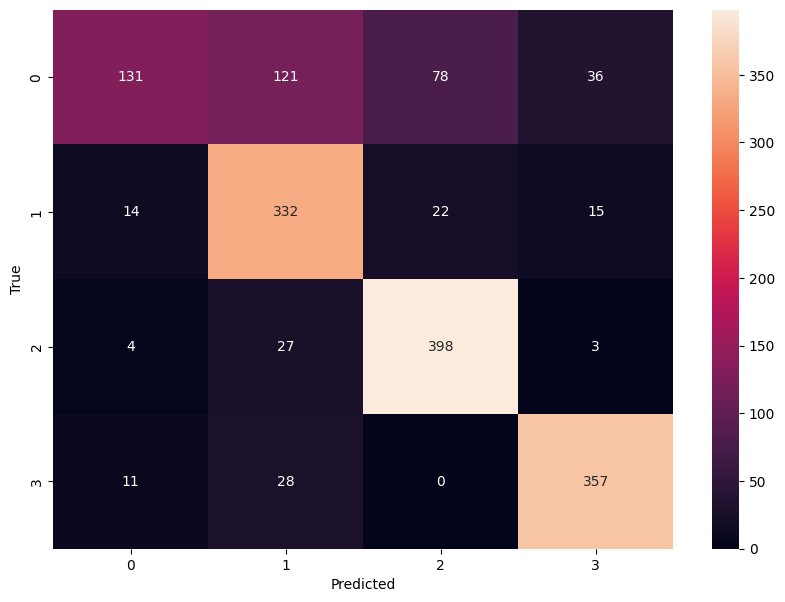

Epoch [2/100], Train Loss: 0.2541, Train Accuracy: 91.04%
Test Loss: 0.2589, Test Accuracy: 91.95%, mAP: 0.9826


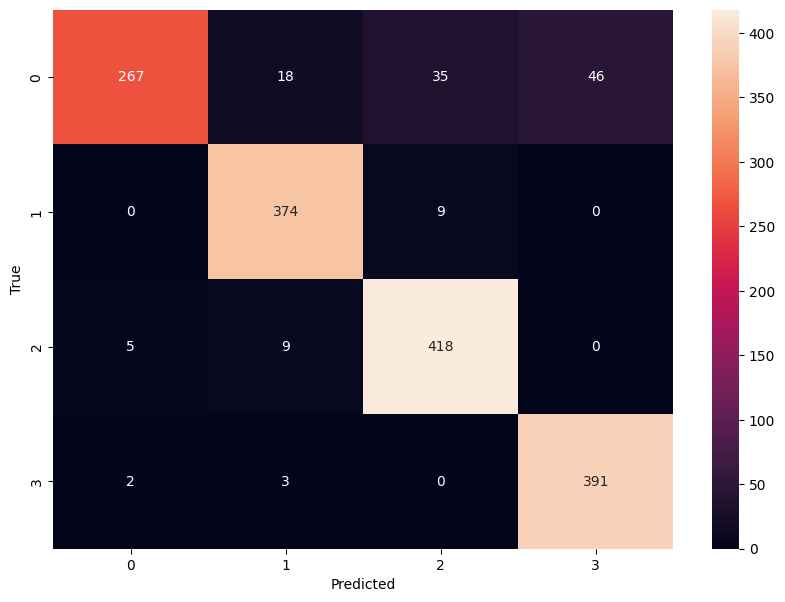

Epoch [3/100], Train Loss: 0.1101, Train Accuracy: 96.48%
Test Loss: 0.1534, Test Accuracy: 94.42%, mAP: 0.9916


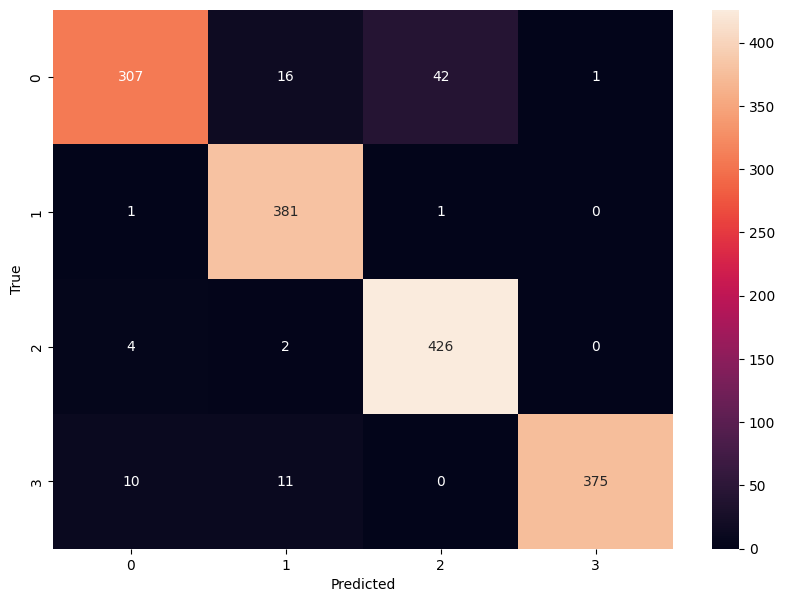

Epoch [4/100], Train Loss: 0.0861, Train Accuracy: 97.18%
Test Loss: 0.0257, Test Accuracy: 99.24%, mAP: 0.9993


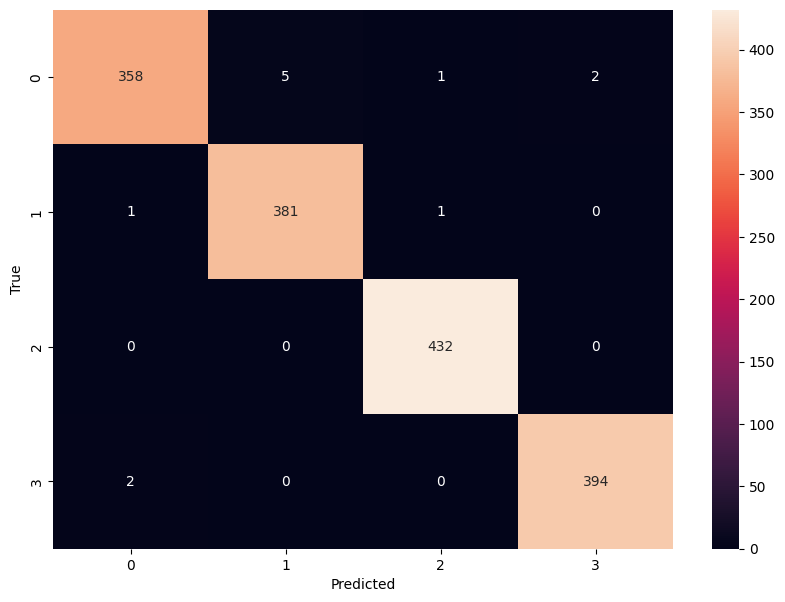

Epoch [5/100], Train Loss: 0.0330, Train Accuracy: 99.10%
Test Loss: 0.0513, Test Accuracy: 99.05%, mAP: 0.9952


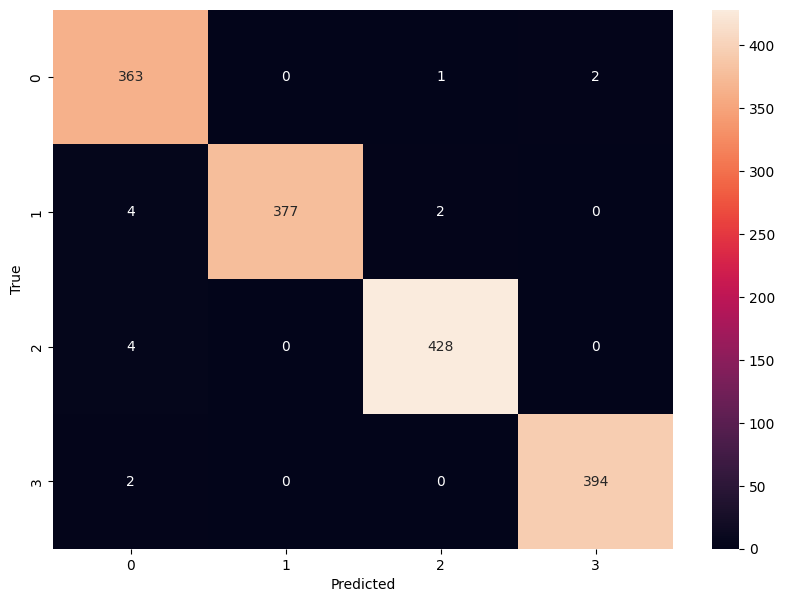

Epoch [6/100], Train Loss: 0.0401, Train Accuracy: 98.91%
Test Loss: 0.0397, Test Accuracy: 98.60%, mAP: 0.9991


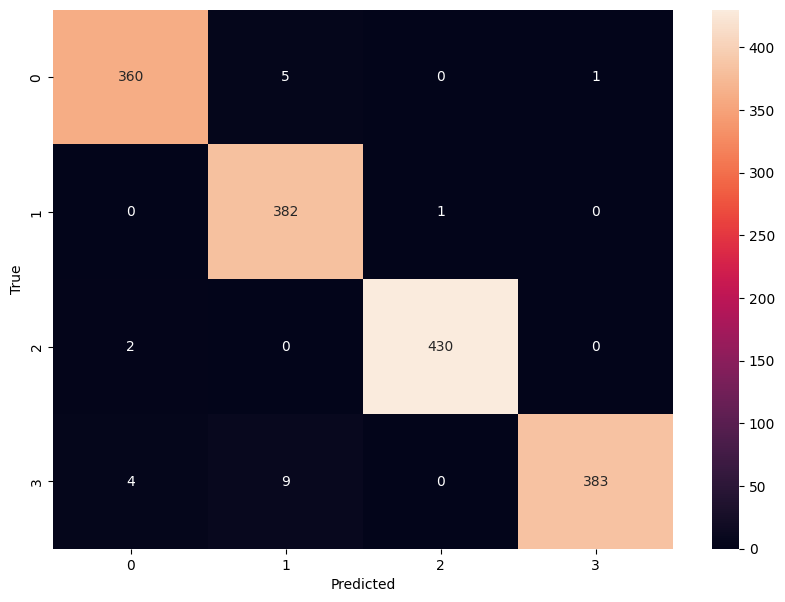

Epoch [7/100], Train Loss: 0.0979, Train Accuracy: 97.13%
Test Loss: 0.0227, Test Accuracy: 99.05%, mAP: 0.9997


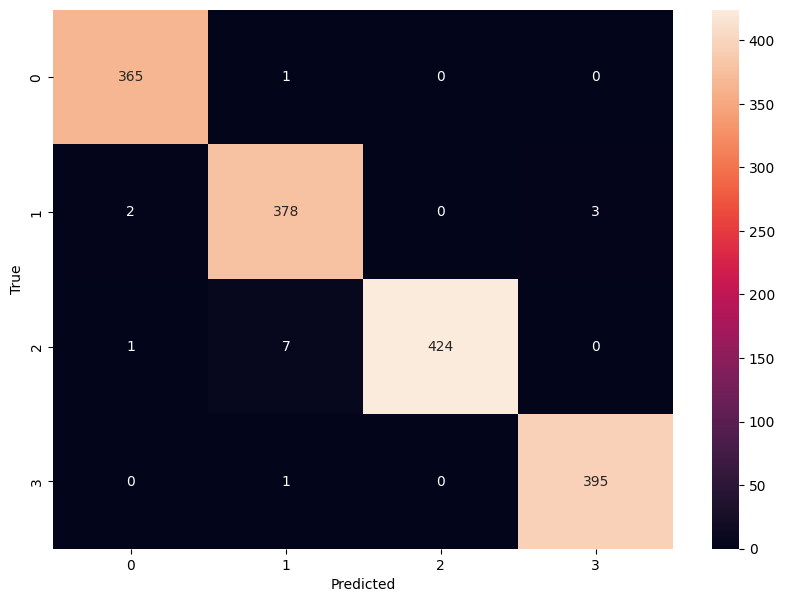

Epoch [8/100], Train Loss: 0.0615, Train Accuracy: 98.16%
Test Loss: 0.0161, Test Accuracy: 99.43%, mAP: 0.9997


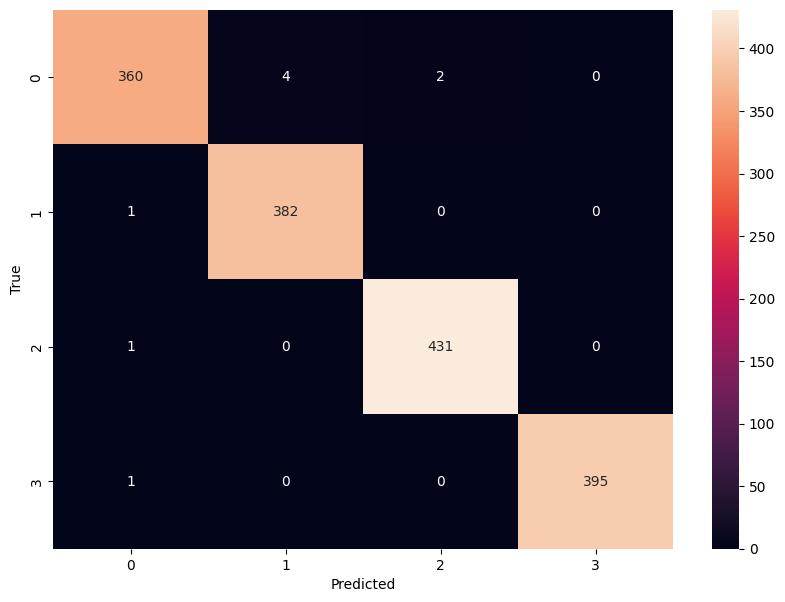

Epoch [9/100], Train Loss: 0.0148, Train Accuracy: 99.62%
Test Loss: 0.0039, Test Accuracy: 99.81%, mAP: 1.0000


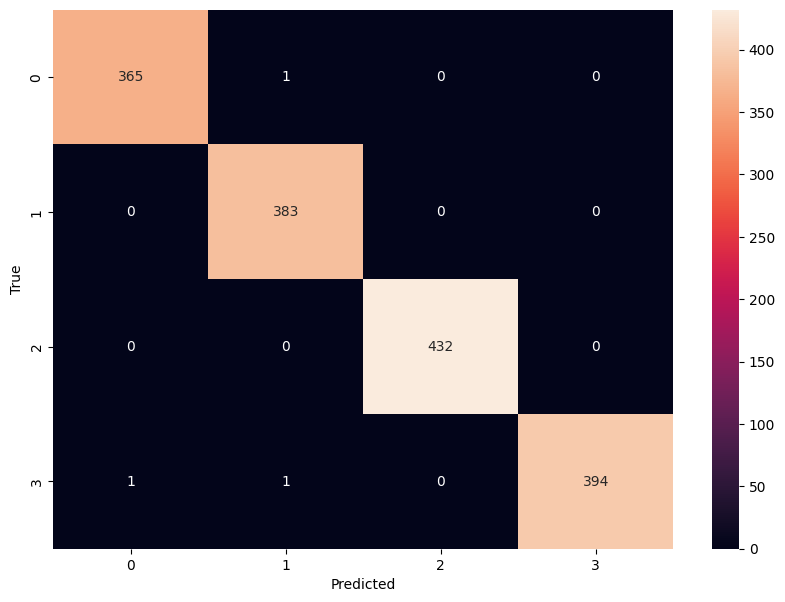

Epoch [10/100], Train Loss: 0.0028, Train Accuracy: 99.92%
Test Loss: 0.0057, Test Accuracy: 99.87%, mAP: 1.0000


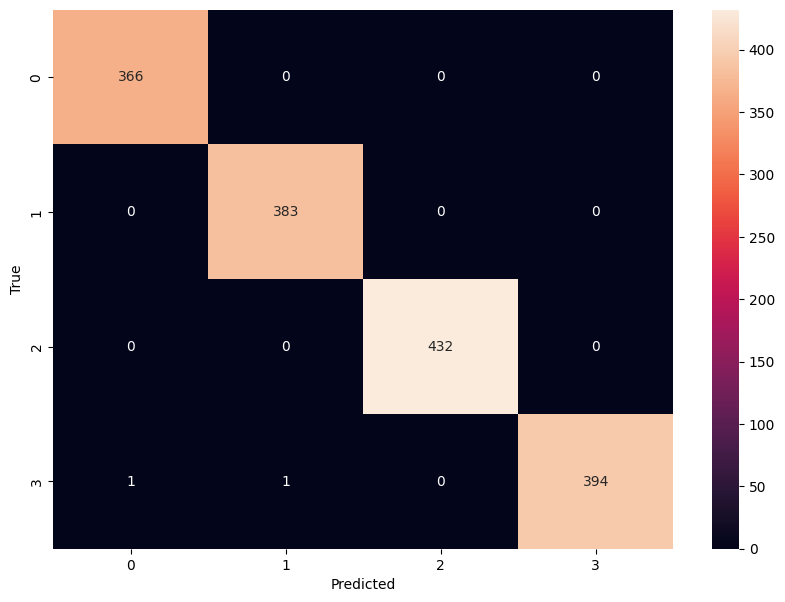

Epoch [11/100], Train Loss: 0.0062, Train Accuracy: 99.81%
Test Loss: 0.0081, Test Accuracy: 99.87%, mAP: 1.0000


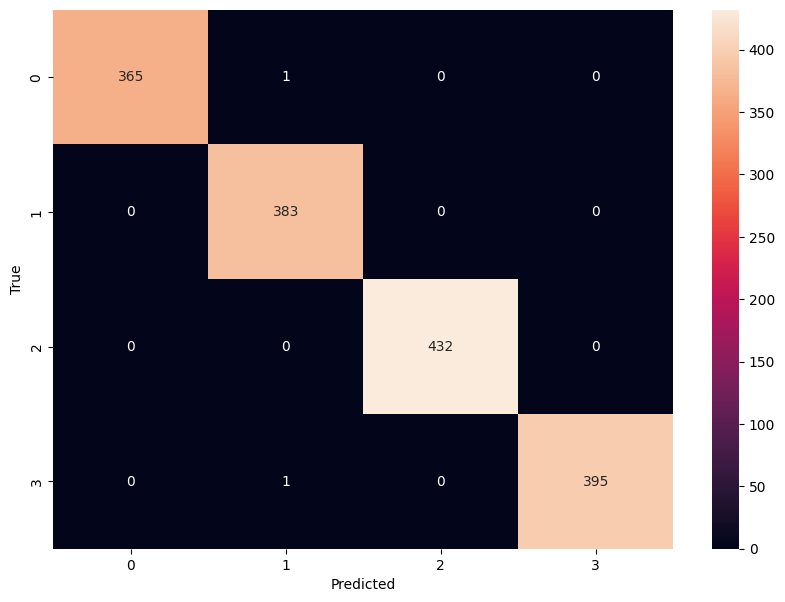

Epoch [12/100], Train Loss: 0.0295, Train Accuracy: 99.13%
Test Loss: 0.2002, Test Accuracy: 94.42%, mAP: 0.9847


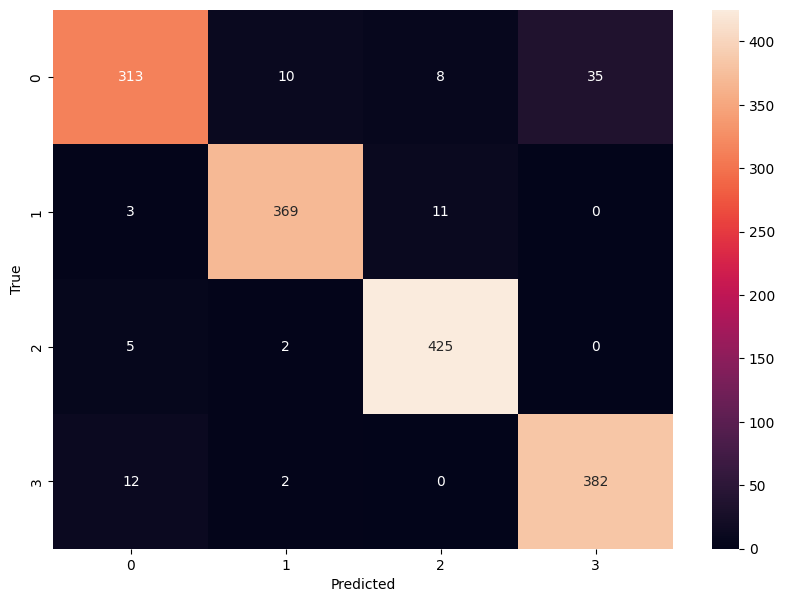

Early stopping at epoch 12


In [17]:
import torch.optim as optim
from torchvision import models
from torch.cuda.amp import GradScaler, autocast
from torchmetrics.classification import MulticlassAveragePrecision, ConfusionMatrix
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Initialize metrics
ap_metric = MulticlassAveragePrecision(num_classes=num_classes, average='macro')
confusion_matrix_metric = ConfusionMatrix(task="multiclass",num_classes=num_classes)
confusion_matrix_metric.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 100
patience = 3  # Number of epochs to wait for improvement before stopping
best_loss = float('inf')
epochs_no_improve = 0


torch.cuda.empty_cache()
model.to(device)

# Initialize mixed precision training
scaler = GradScaler()

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        # Mixed precision training
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = 100. * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%')

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(outputs.cpu())
            all_labels.extend(labels.cpu())

            # Update AP metric and confusion matrix
            ap_metric.update(preds=outputs, target=labels)
            confusion_matrix_metric.update(preds=predicted, target=labels)

    test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = 100. * correct / total

    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Compute mAP
    mAP_score = ap_metric.compute().item()
    ap_metric.reset()

    print(f'Test Loss: {test_loss:.4f}, '
          f'Test Accuracy: {test_accuracy:.2f}%, '
          f'mAP: {mAP_score:.4f}')

    # Compute confusion matrix
    conf_matrix = confusion_matrix_metric.compute().cpu().numpy()
    confusion_matrix_metric.reset()

    # Plot confusion matrix
    df_cm = pd.DataFrame(conf_matrix, index=[i for i in range(num_classes)], columns=[i for i in range(num_classes)])
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    # Early Stopping
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            epoch_plt = epoch + 1
            print(f'Early stopping at epoch {epoch + 1}')
            break


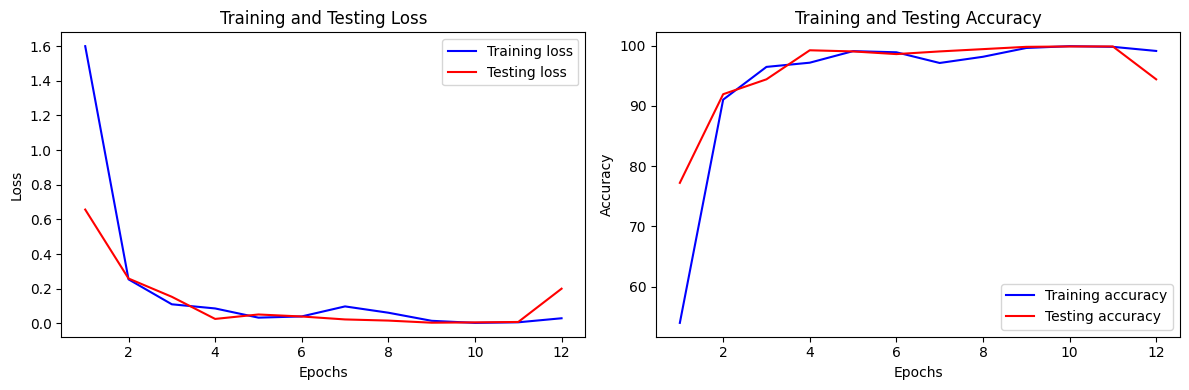

In [18]:
# Plotting the training and testing loss and accuracy
import matplotlib.pyplot as plt

epochs = range(1, epoch_plt + 1)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training loss')
plt.plot(epochs, test_losses, 'r', label='Testing loss')
plt.title('Training and Testing Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training accuracy')
plt.plot(epochs, test_accuracies, 'r', label='Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()